# Which Bird Are You
Recognising birds by their song using CNNs.

In [1]:
import keras

2025-11-20 13:50:01.866033: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-20 13:50:01.915480: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-20 13:50:03.182144: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-20 13:50:03.182144: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


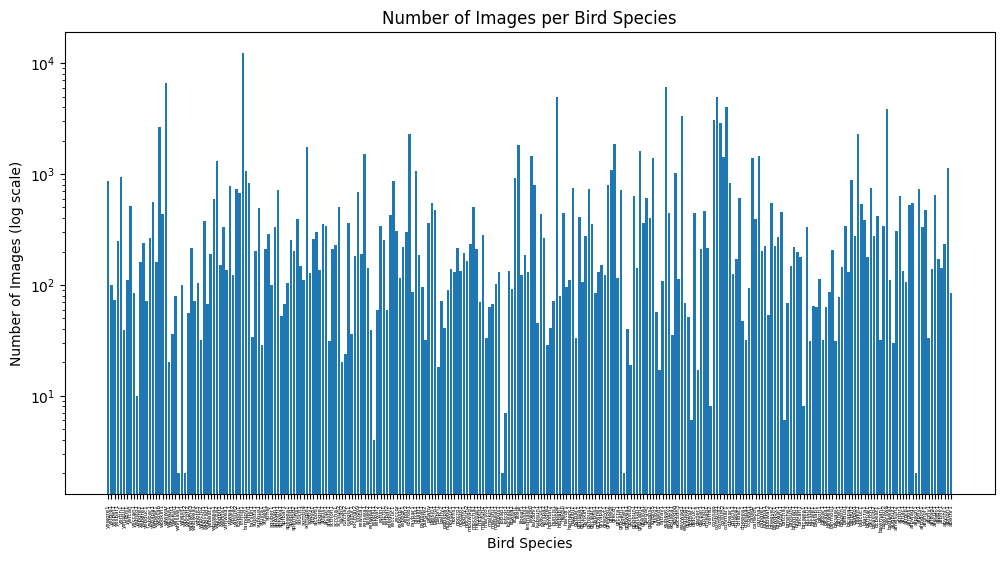

In [2]:
# Show a plot of number of images per class for all classes
import os
import matplotlib.pyplot as plt

bird_dirs = [d for d in os.listdir("data") if os.path.isdir(os.path.join("data", d))]
num_images_per_class = []
for bird in bird_dirs:
    bird_dir = os.path.join("data", bird)
    num_images = len(os.listdir(bird_dir))
    num_images_per_class.append(num_images)

plt.figure(figsize=(12, 6))
plt.bar(bird_dirs, num_images_per_class)
plt.xticks(rotation=90, fontsize=4)
plt.yscale("log")
plt.xlabel("Bird Species")
plt.ylabel("Number of Images (log scale)")
plt.title("Number of Images per Bird Species")
plt.show()

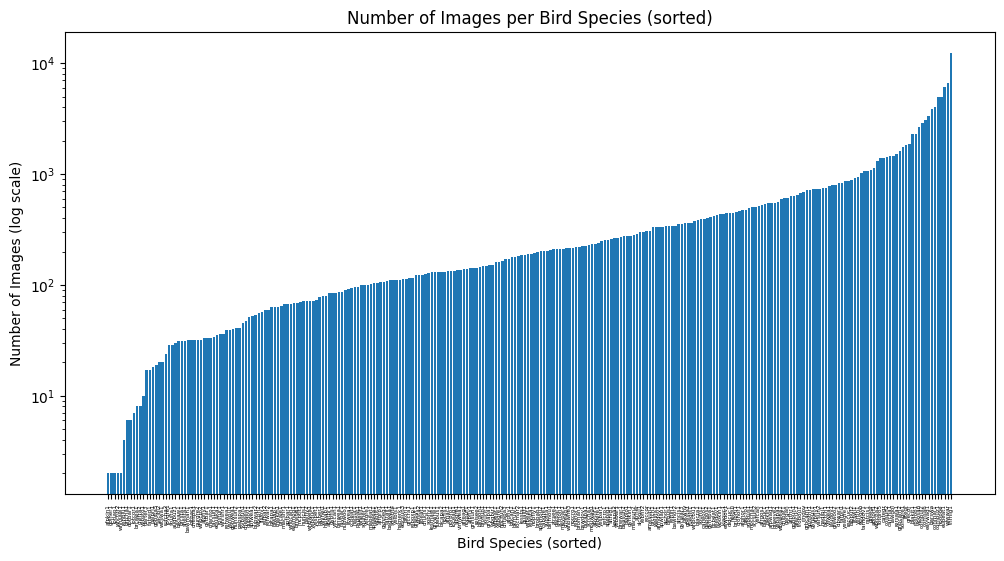

In [3]:
# Do the same plot but now sorted by number of images
sorted_bird_dirs = [x for _, x in sorted(zip(num_images_per_class, bird_dirs))]
sorted_num_images_per_class = sorted(num_images_per_class)
plt.figure(figsize=(12, 6))
plt.bar(sorted_bird_dirs, sorted_num_images_per_class)
plt.xticks(rotation=90, fontsize=4)
plt.yscale("log")
plt.xlabel("Bird Species (sorted)")
plt.ylabel("Number of Images (log scale)")
plt.title("Number of Images per Bird Species (sorted)")
plt.show()

## Data loading

In [4]:
from keras.utils import image_dataset_from_directory
import random
import os

batch_size = 32
image_size = (128, 128)
seed = 30

# Get 4 random bird species
all_birds = os.listdir("data")
random.seed(seed)
selected_birds = random.sample(all_birds, 4)
print(f"Selected birds: {selected_birds}")

# images  per class
for bird in selected_birds:
    bird_dir = os.path.join("data", bird)
    num_images = len(os.listdir(bird_dir))
    print(f"{bird}: {num_images} images")

# If you need train/val split, repeat for both
train_dataset, val_dataset = image_dataset_from_directory(
    "data",
    class_names=selected_birds,
    batch_size=batch_size,
    image_size=image_size,
    color_mode="grayscale",
    shuffle=True,
    subset="both",
    seed=seed,
    validation_split=0.2,
)

# Preprocessing: Normalize pixel values to [-1, 1]
normalization_layer = keras.layers.Rescaling(1.0 / 127.5, offset=-1.0)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

if False:
    f = 0.2

    train_dataset = train_dataset.take(int(f * len(train_dataset)))
    val_dataset = val_dataset.take(int(f * len(val_dataset)))

Selected birds: ['gyhneg1', 'wtbeat1', 'norpuf1', 'lesmaw1']
gyhneg1: 106 images
wtbeat1: 160 images
norpuf1: 139 images
lesmaw1: 130 images
Found 535 files belonging to 4 classes.


Using 428 files for training.
Using 107 files for validation.
Using 107 files for validation.


2025-11-20 13:50:06.177452: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Visualisation

2025-11-20 13:50:06.396320: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


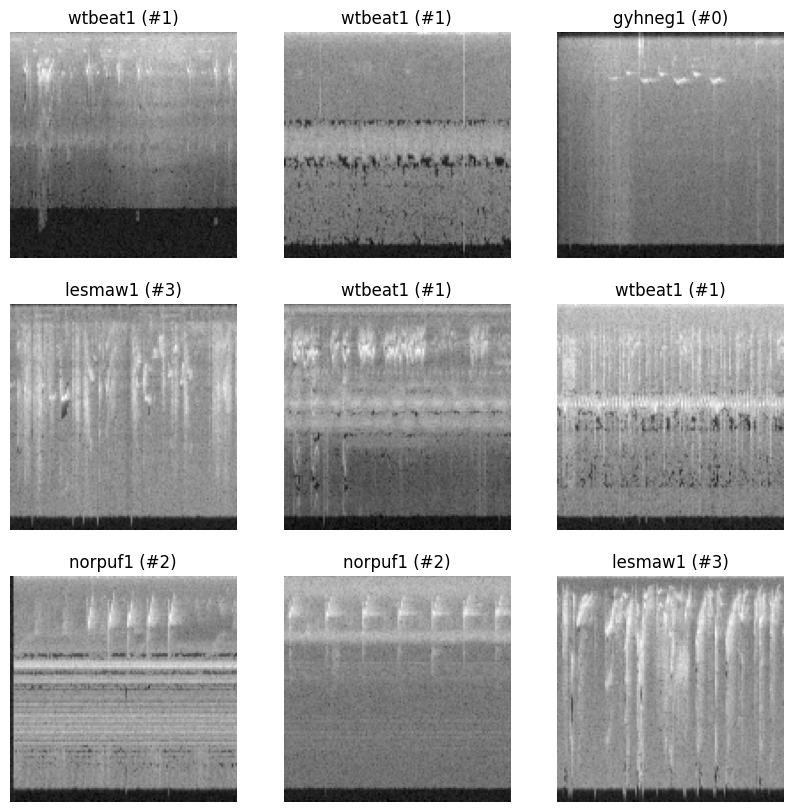

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import os

idx_to_bird = {
    i: name for i, name in enumerate(selected_birds)
}

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = (np.array(images[i]) + 1) / 2
        plt.imshow(image, cmap="gray")
        idx = int(labels[i])
        plt.title(f"{idx_to_bird[idx]} (#{idx})")
        plt.axis("off")


## Training

In [6]:
input_shape = (*image_size, 1)
num_classes = len(selected_birds)

# Model using Functional API with Batch Normalization and LeakyReLU
inputs = keras.layers.Input(shape=input_shape)
x = keras.layers.Conv2D(64, kernel_size=(3, 3), use_bias=False, name="conv2d_1")(inputs)
x = keras.layers.BatchNormalization(name="batch_norm_1")(x)
x = keras.layers.LeakyReLU(alpha=0.2, name="leaky_relu_1")(x)

x = keras.layers.Conv2D(64, kernel_size=(3, 3), use_bias=False, name="conv2d_2")(x)
x = keras.layers.BatchNormalization(name="batch_norm_2")(x)
x = keras.layers.LeakyReLU(alpha=0.2, name="leaky_relu_2")(x)

x = keras.layers.MaxPooling2D(pool_size=(2, 2), name="max_pooling2d")(x)

x = keras.layers.Conv2D(128, kernel_size=(3, 3), use_bias=False, name="conv2d_3")(x)
x = keras.layers.BatchNormalization(name="batch_norm_3")(x)
x = keras.layers.LeakyReLU(alpha=0.2, name="leaky_relu_3")(x)

x = keras.layers.Conv2D(128, kernel_size=(3, 3), use_bias=False, name="conv2d_4")(x)
x = keras.layers.BatchNormalization(name="batch_norm_4")(x)
x = keras.layers.LeakyReLU(alpha=0.2, name="leaky_relu_4")(x)

x = keras.layers.GlobalAveragePooling2D(name="global_average_pooling2d")(x)
# x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(num_classes, activation="softmax", name="dense")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="bird_classifier")

model.summary()

/home/nikolaj/Projects/which-bird-are-you/.venv/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "bird_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 64)   │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 126, 126, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_1 (LeakyReLU)        │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 64)   │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 124, 124, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_2 (LeakyReLU)        │ (None, 124, 124, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_3                    │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_3 (LeakyReLU)        │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 58, 58, 128)    │       147,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_4                    │ (None, 58, 58, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_relu_4 (LeakyReLU)        │ (None, 58, 58, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 260,676 (1018.27 KB)

 Trainable params: 259,908 (1015.27 KB)

 Non-trainable params: 768 (3.00 KB)

In [7]:
opt = keras.optimizers.Adam(learning_rate=2e-4)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=opt,
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc"),
    ],
)

In [8]:
from tqdm.keras import TqdmCallback

os.makedirs("epochs", exist_ok=True)
epochs = 200

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="epochs/model_at_epoch_{epoch}.keras"),
    TqdmCallback(verbose=1),
]

print("Starting training...")
print(f"Model input shape: {model.input_shape}")
print(f"Model output shape: {model.output_shape}")

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=0,
)

print("Training completed!")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Starting training...
Model input shape: (None, 128, 128, 1)
Model output shape: (None, 4)
Training completed!
Training completed!


## Results

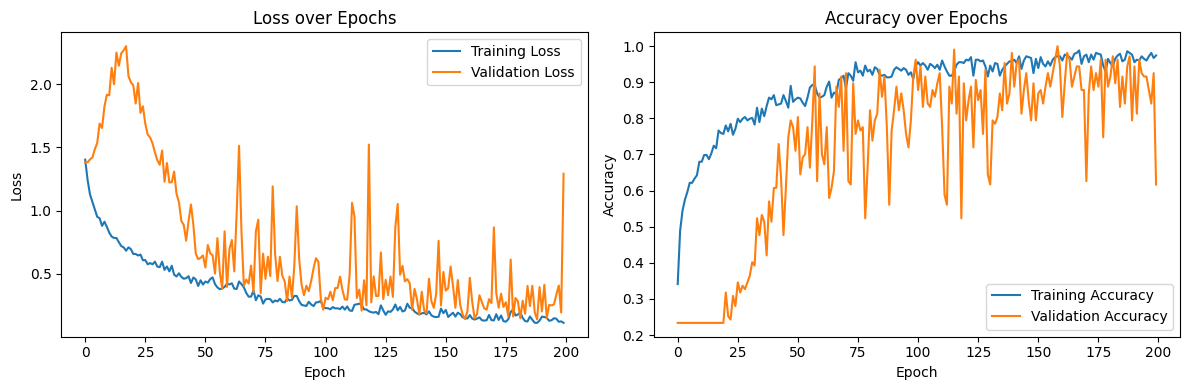

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.tight_layout()
plt.show()

2025-11-20 15:22:49.358182: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


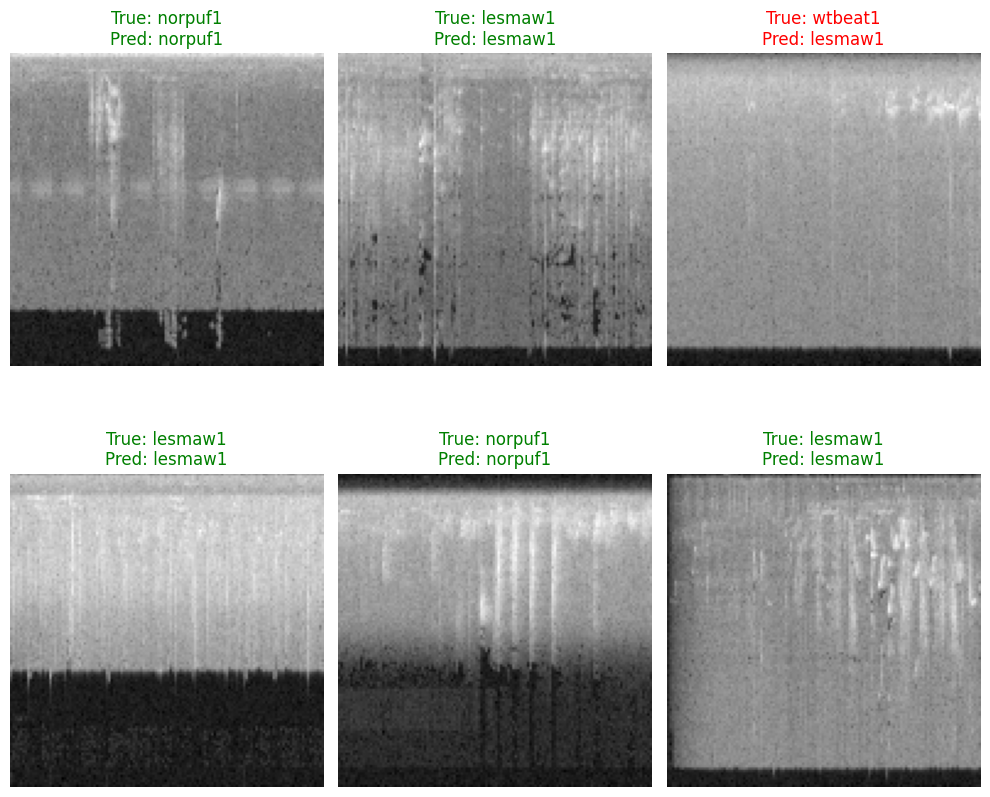

In [10]:
plt.figure(figsize=(10, 9))

# Get one batch from the validation dataset
for images, labels in val_dataset.take(1):
    predictions = model(images, training=False)

    for i in range(min(6, len(images))):
        image = (np.array(images[i]) + 1) / 2

        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(image, cmap="gray")

        true_idx = int(labels[i])
        predicted_idx = np.argmax(predictions[i])

        true_label = idx_to_bird[true_idx]
        predicted_label = idx_to_bird[predicted_idx]

        color = 'green' if true_idx == predicted_idx else 'red'
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis("off")

plt.tight_layout()
plt.show()

## What Has the Model Learned
We will use GradCAM to visualize which parts of the image the model uses to determine the prediction label.

Using last convolutional layer: conv2d_4


/tmp/ipykernel_107999/2806596131.py:65: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


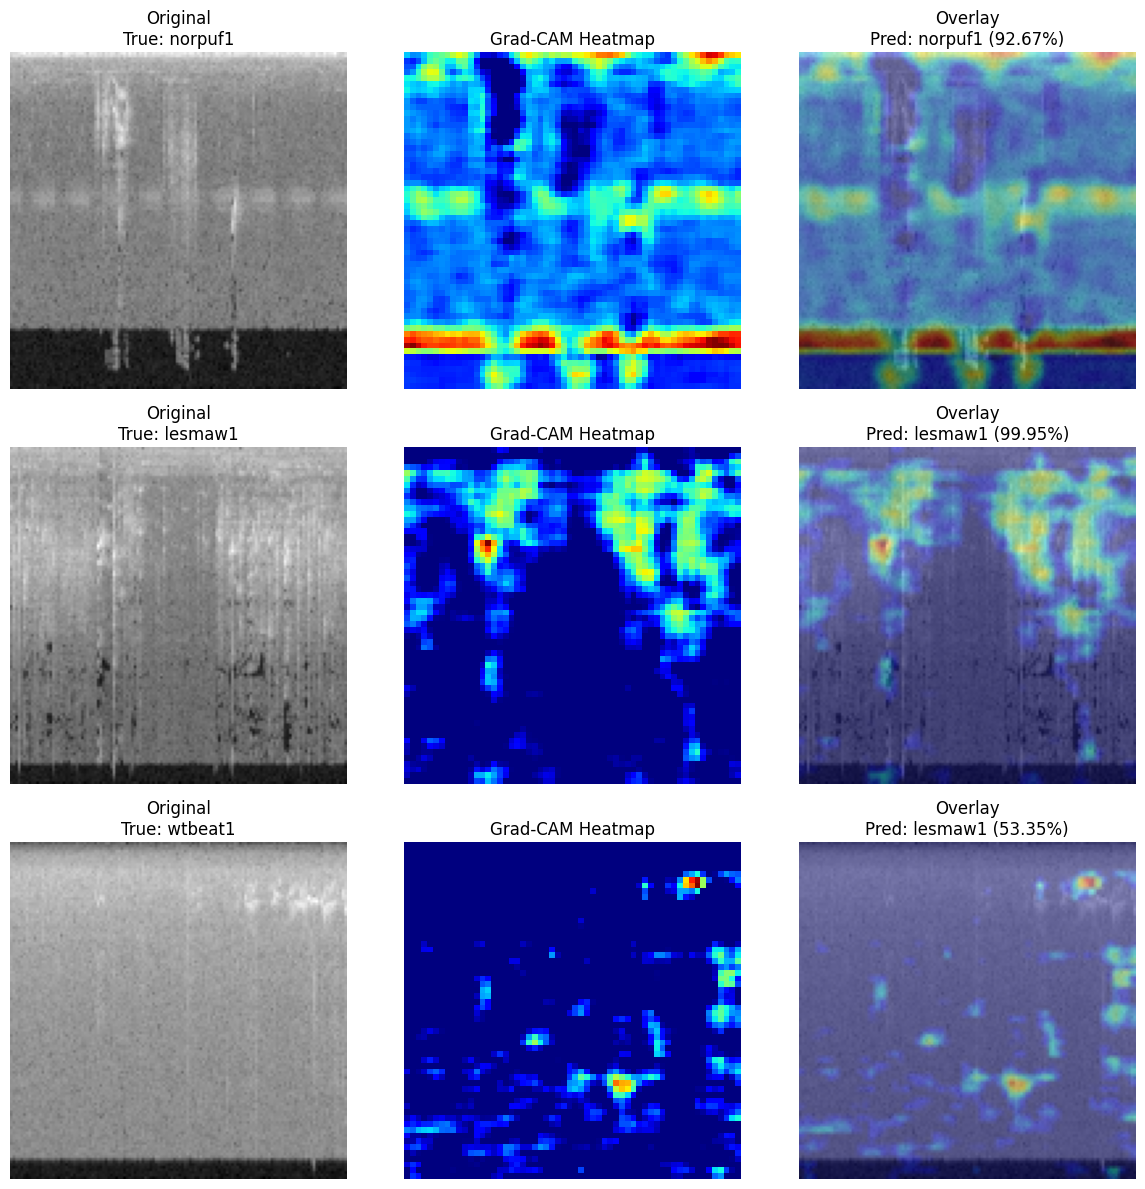

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generate Grad-CAM heatmap for a given image.
    
    Args:
        img_array: Input image array
        model: Trained model
        last_conv_layer_name: Name of the last convolutional layer
        pred_index: Target class index (if None, uses predicted class)
    
    Returns:
        heatmap: Grad-CAM heatmap
    """
    # Create a model that maps the input image to the activations of the last conv layer
    # and the output predictions
    grad_model = keras.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    
    # Gradient of the output neuron with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # Vector of mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Multiply each channel in the feature map array by importance of that channel
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize the heatmap between 0 & 1 for visualization
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def save_and_display_gradcam(img, heatmap, alpha=0.4):
    """
    Superimpose the heatmap on original image.
    
    Args:
        img: Original image (normalized to [-1, 1])
        heatmap: Grad-CAM heatmap
        alpha: Transparency of heatmap overlay
    
    Returns:
        superimposed_img: Image with heatmap overlay
    """
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # Resize the heatmap to match the image size
    from PIL import Image
    jet_heatmap_img = Image.fromarray(np.uint8(jet_heatmap * 255))
    jet_heatmap_img = jet_heatmap_img.resize((img.shape[1], img.shape[0]))
    jet_heatmap = np.array(jet_heatmap_img) / 255.0
    
    # Convert grayscale to RGB if needed
    if img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)
    
    # Denormalize image from [-1, 1] to [0, 255]
    img = (img + 1.0) * 127.5
    img = np.clip(img, 0, 255)
    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 255 * alpha + img * (1 - alpha)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    return superimposed_img


# Get 3 images from validation dataset
sample_images = []
sample_labels = []

for images, labels in val_dataset.take(1):
    # Take first 3 images from the batch
    for i in range(min(3, len(images))):
        sample_images.append(images[i])
        sample_labels.append(labels[i])

# Find the last convolutional layer name
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

print(f"Using last convolutional layer: {last_conv_layer_name}")

# Create Grad-CAM visualizations
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for idx, (img, label) in enumerate(zip(sample_images, sample_labels)):
    # Prepare image for prediction
    img_array = tf.expand_dims(img, 0)
    
    # Get prediction
    preds = model.predict(img_array, verbose=0)
    pred_class = np.argmax(preds[0])
    pred_prob = preds[0][pred_class]
    
    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    
    # Create superimposed image
    superimposed_img = save_and_display_gradcam(img.numpy(), heatmap)
    
    # Display original image
    # Denormalize for display from [-1, 1] to [0, 1]
    img_display = (img.numpy() + 1.0) / 2.0
    axes[idx, 0].imshow(img_display.squeeze(), cmap='gray')
    axes[idx, 0].set_title(f'Original\nTrue: {idx_to_bird[int(label.numpy())]}')
    axes[idx, 0].axis('off')
    
    # Display heatmap
    axes[idx, 1].imshow(heatmap, cmap='jet')
    axes[idx, 1].set_title('Grad-CAM Heatmap')
    axes[idx, 1].axis('off')
    
    # Display superimposed image
    axes[idx, 2].imshow(superimposed_img)
    axes[idx, 2].set_title(f'Overlay\nPred: {idx_to_bird[pred_class]} ({pred_prob:.2%})')
    axes[idx, 2].axis('off')

plt.tight_layout()
# plt.savefig('gradcam_visualization.png', dpi=150, bbox_inches='tight')
plt.show()